In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

def check_dataset_structure(base_path):
    print(f"--- Analyzing: {base_path} ---")
    for root, dirs, files in os.walk(base_path):
        # Смотрим только на первый уровень вложенности для краткости
        level = root.replace(base_path, '').count(os.sep)
        if level <= 1:
            indent = ' ' * 4 * level
            print(f"{indent}[{os.path.basename(root)}] - Files: {len(files)}")

# Проверяем структуру по твоим путям
train_path = '/kaggle/input/datasets/aivauzun/data-lake/train/train'
test_path = '/kaggle/input/datasets/aivauzun/data-lake/test/test_upload'

check_dataset_structure(train_path)
check_dataset_structure(test_path)

--- Analyzing: /kaggle/input/datasets/aivauzun/data-lake/train/train ---
[train] - Files: 0
    [7] - Files: 1207
    [2] - Files: 1458
    [5] - Files: 1631
    [8] - Files: 1765
    [0] - Files: 1613
    [3] - Files: 1528
    [1] - Files: 1971
    [4] - Files: 1400
    [9] - Files: 1255
    [6] - Files: 1733
--- Analyzing: /kaggle/input/datasets/aivauzun/data-lake/test/test_upload ---
[test_upload] - Files: 6675


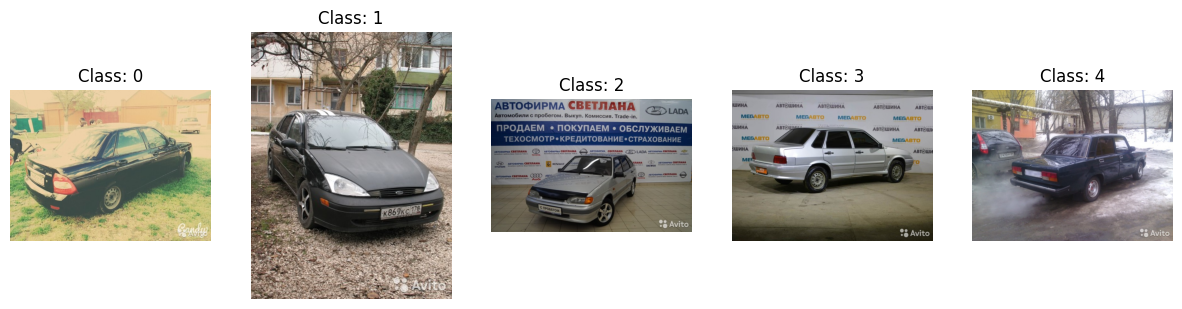

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# Визуализация примеров
def show_examples(root_path, classes, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(classes[:num_images]):
        cls_path = os.path.join(root_path, cls)
        img_name = os.listdir(cls_path)[0]
        img = Image.open(os.path.join(cls_path, img_name))
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {cls}")
        plt.axis('off')
    plt.show()

train_path = '/kaggle/input/datasets/aivauzun/data-lake/train/train'
classes = sorted(os.listdir(train_path))
show_examples(train_path, classes)

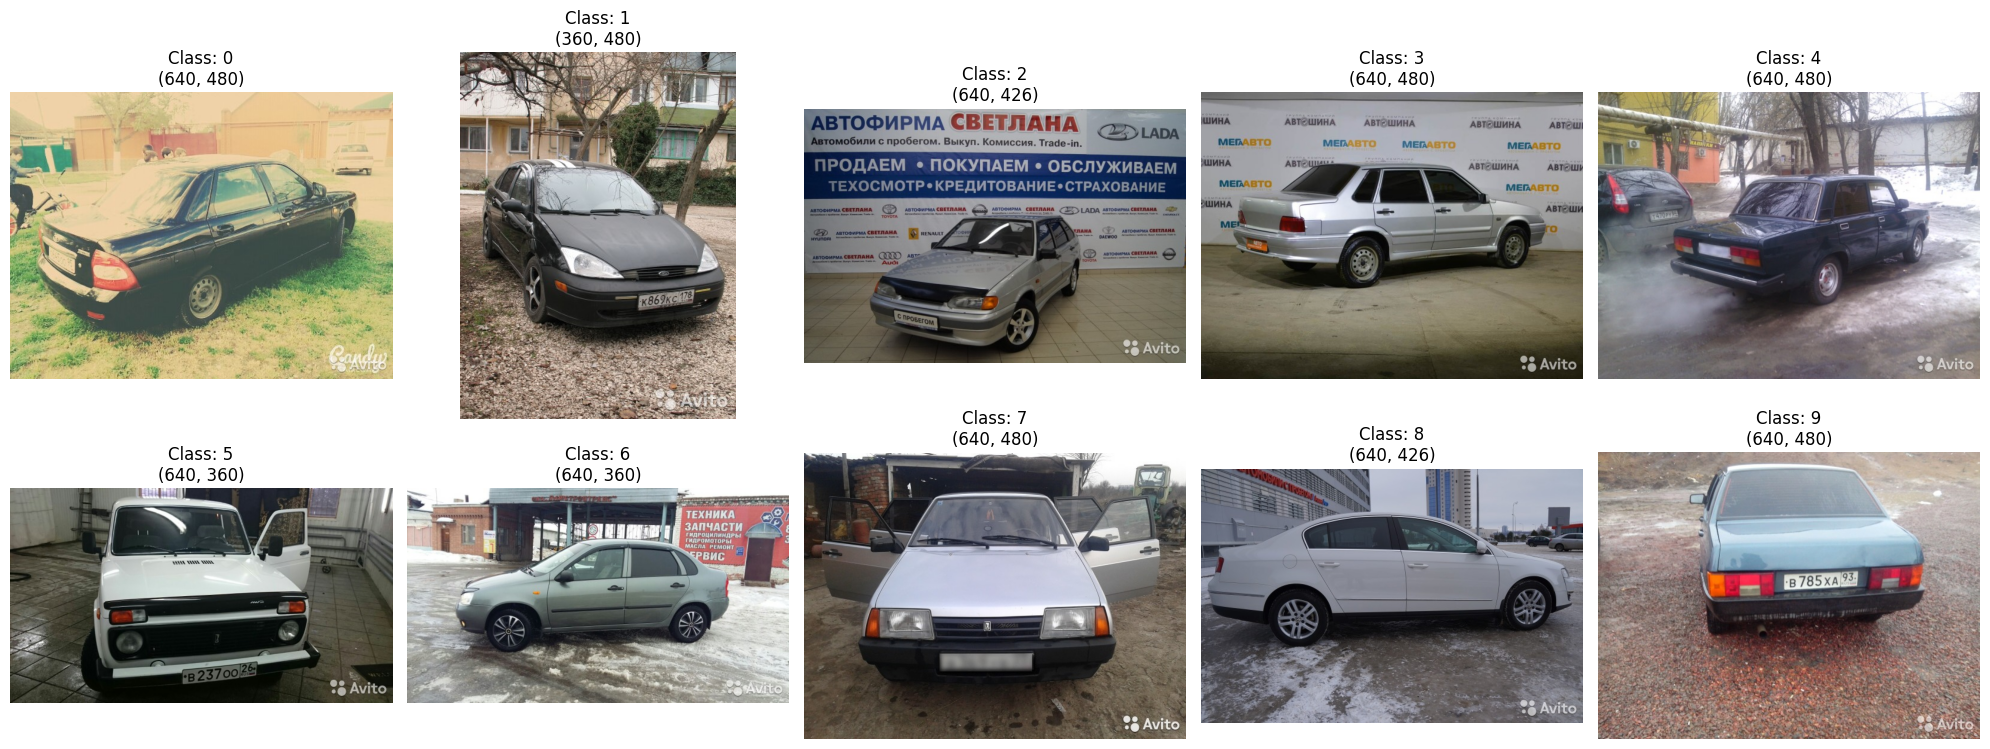

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Визуализация примеров из каждого класса
def visualize_classes(base_path):
    classes = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_path, cls)
        img_name = os.listdir(cls_dir)[0]
        img_path = os.path.join(cls_dir, img_name)
        
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {cls}\n{img.size}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

train_dir = '/kaggle/input/datasets/aivauzun/data-lake/train/train'
visualize_classes(train_dir)

In [5]:
from collections import Counter
from tqdm import tqdm

# Сбор статистики по размерам изображений
def get_image_size_stats(root_path):
    sizes = []
    classes = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    
    for cls in classes:
        cls_dir = os.path.join(root_path, cls)
        files = os.listdir(cls_dir)
        for f in files:
            img_path = os.path.join(cls_dir, f)
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)
            except:
                continue
                
    size_counts = Counter(sizes)
    return size_counts

train_dir = '/kaggle/input/datasets/aivauzun/data-lake/train/train'
stats = get_image_size_stats(train_dir)

# Вывод топ-10 самых частых размеров
print(f"{'Size (W, H)':<20} | {'Count':<10}")
print("-" * 35)
for size, count in stats.most_common(10):
    print(f"{str(size):<20} | {count:<10}")

print(f"\nTotal unique sizes: {len(stats)}")

Size (W, H)          | Count     
-----------------------------------
(640, 480)           | 7843      
(640, 360)           | 2688      
(360, 480)           | 995       
(640, 427)           | 550       
(640, 384)           | 400       
(640, 478)           | 324       
(270, 480)           | 211       
(640, 477)           | 181       
(640, 361)           | 179       
(604, 453)           | 177       

Total unique sizes: 480


In [6]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

# Оптимальные трансформации для baseline
# Используем CenterCrop, чтобы минимизировать искажения кузова
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Инициализируем датасет
full_dataset = datasets.ImageFolder(root='/kaggle/input/datasets/aivauzun/data-lake/train/train', transform=transform)

# Разбиение на Train и Val (фиксируем random_state для воспроизводимости)
train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    random_state=42,
    stratify=full_dataset.targets # Сохраняем баланс классов
)

train_data = Subset(full_dataset, train_idx)
val_data = Subset(full_dataset, val_idx)

# Создаем загрузчики
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)

print(f"Train size: {len(train_data)}")
print(f"Val size: {len(val_data)}")
print(f"Classes: {full_dataset.classes}")

Train size: 12448
Val size: 3113
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Baseline модель
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()
        # Первый блок: из 3 каналов в 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Второй блок: из 16 в 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Третий блок: из 32 в 64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # После 3 пулингов 224x224 -> 112 -> 56 -> 28
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_baseline = BaselineCNN(num_classes=10).to(device)

In [8]:
import torch.optim as optim
from sklearn.metrics import f1_score

# Функция обучения и валидации
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_f1': []}
    
    for epoch in range(epochs):
        # Режим обучения
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Режим валидации
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Считаем метрику F1 (weighted учитывает дисбаланс, если он есть)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = running_loss / len(train_loader)
        
        history['train_loss'].append(avg_loss)
        history['val_f1'].append(epoch_f1)
        
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Val F1: {epoch_f1:.4f}")
    
    return history

# Запуск обучения Baseline
print("--- Training Baseline Model ---")
baseline_history = train_model(model_baseline, train_loader, val_loader, epochs=5)

--- Training Baseline Model ---
Epoch [1/5] | Loss: 2.5986 | Val F1: 0.0284
Epoch [2/5] | Loss: 2.2951 | Val F1: 0.0284
Epoch [3/5] | Loss: 2.2931 | Val F1: 0.0284
Epoch [4/5] | Loss: 2.2926 | Val F1: 0.0284
Epoch [5/5] | Loss: 2.2924 | Val F1: 0.0284


In [9]:
from torchvision.models import resnet50, ResNet50_Weights

# Загружаем предобученную модель
model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Замораживаем веса всех слоев
for param in model_resnet.parameters():
    param.requires_grad = False

# Заменяем финальный полносвязный слой (FC)
# В ResNet50 вход в FC слой имеет 2048 признаков
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 10)

model_resnet = model_resnet.to(device)

# Для Transfer Learning используем чуть меньший LR, чтобы не "сломать" веса классификатора
print("--- Training ResNet50 (Transfer Learning) ---")
resnet_history = train_model(model_resnet, train_loader, val_loader, epochs=5, lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


--- Training ResNet50 (Transfer Learning) ---
Epoch [1/5] | Loss: 1.4109 | Val F1: 0.6233
Epoch [2/5] | Loss: 1.0463 | Val F1: 0.6536
Epoch [3/5] | Loss: 0.9436 | Val F1: 0.6693
Epoch [4/5] | Loss: 0.9028 | Val F1: 0.6583
Epoch [5/5] | Loss: 0.8552 | Val F1: 0.6701


In [10]:
# Размораживаем все параметры
for param in model_resnet.parameters():
    param.requires_grad = True

# Уменьшаем Learning Rate для бережного дообучения
optimizer_ft = optim.Adam(model_resnet.parameters(), lr=0.0001)

print("--- Fine-tuning ResNet50 (Unfrozen layers) ---")
# Продолжаем обучение еще 5 эпох
fine_tuning_history = train_model(model_resnet, train_loader, val_loader, epochs=5, lr=0.0001)

--- Fine-tuning ResNet50 (Unfrozen layers) ---
Epoch [1/5] | Loss: 0.4017 | Val F1: 0.8973
Epoch [2/5] | Loss: 0.1183 | Val F1: 0.8970
Epoch [3/5] | Loss: 0.0918 | Val F1: 0.9101
Epoch [4/5] | Loss: 0.0673 | Val F1: 0.9144
Epoch [5/5] | Loss: 0.0643 | Val F1: 0.9144


In [15]:
import torch
import torch.nn as nn
from torchvision import models

# Универсальный способ загрузки предобученной модели
try:
    # Для новых версий torchvision
    model_mobilenet = models.mobilenet_v2(weights=models.MobileNetV2_Weights.IMAGENET1K_V1)
except AttributeError:
    # Для старых версий (Kaggle/Colab)
    model_mobilenet = models.mobilenet_v2(pretrained=True)

# Размораживаем веса для Fine-tuning
for param in model_mobilenet.parameters():
    param.requires_grad = True

# Заменяем классификатор
num_ftrs = model_mobilenet.classifier[1].in_features
model_mobilenet.classifier[1] = nn.Linear(num_ftrs, 10)

model_mobilenet = model_mobilenet.to(device)

print("--- Training MobileNetV2 (Fine-tuning) ---")
# Запускаем обучение
mobilenet_history = train_model(model_mobilenet, train_loader, val_loader, epochs=5, lr=0.0001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 122MB/s]

--- Training MobileNetV2 (Fine-tuning) ---


Epoch [1/5] | Loss: 0.7161 | Val F1: 0.9107
Epoch [2/5] | Loss: 0.2158 | Val F1: 0.9200
Epoch [3/5] | Loss: 0.1254 | Val F1: 0.9252
Epoch [4/5] | Loss: 0.0778 | Val F1: 0.9210
Epoch [5/5] | Loss: 0.0530 | Val F1: 0.9267


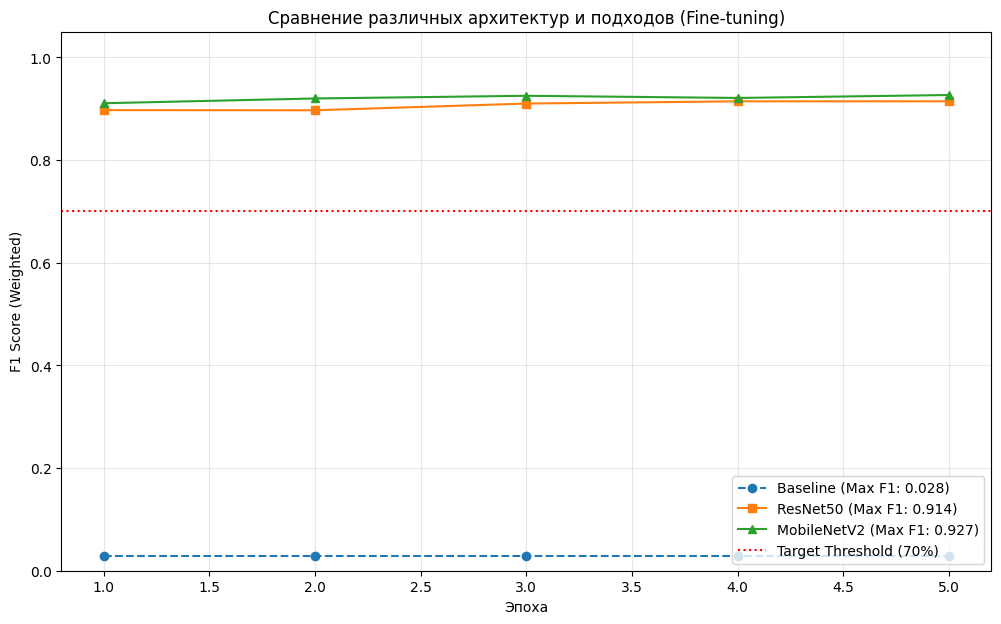

In [16]:
import matplotlib.pyplot as plt

def plot_final_results(base_h, resnet_h, mobile_h):
    plt.figure(figsize=(12, 7))
    
    # Собираем лучшие показатели
    final_scores = {
        'Baseline (Simple CNN)': max(base_h['val_f1']),
        'ResNet50 (Fine-tuned)': max(resnet_h['val_f1']),
        'MobileNetV2 (Fine-tuned)': max(mobile_h['val_f1'])
    }
    
    # График динамики по эпохам
    epochs = range(1, 6)
    plt.plot(epochs, base_h['val_f1'], 'o--', label=f"Baseline (Max F1: {final_scores['Baseline (Simple CNN)']:.3f})")
    plt.plot(epochs, resnet_h['val_f1'], 's-', label=f"ResNet50 (Max F1: {final_scores['ResNet50 (Fine-tuned)']:.3f})")
    plt.plot(epochs, mobile_h['val_f1'], '^-', label=f"MobileNetV2 (Max F1: {final_scores['MobileNetV2 (Fine-tuned)']:.3f})")
    
    plt.axhline(y=0.7, color='r', linestyle=':', label='Target Threshold (70%)')
    
    plt.title('Сравнение различных архитектур и подходов (Fine-tuning)')
    plt.xlabel('Эпоха')
    plt.ylabel('F1 Score (Weighted)')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)
    plt.show()

plot_final_results(baseline_history, fine_tuning_history, mobilenet_history)

In [17]:
# Расширенные трансформации для обучения
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Случайный зум
    transforms.RandomHorizontalFlip(p=0.5),             # Отражение
    transforms.RandomRotation(15),                      # Повороты
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Освещение
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Для валидации оставляем как было
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Переинициализируем датасеты
full_dataset_aug = datasets.ImageFolder(root='/kaggle/input/datasets/aivauzun/data-lake/train/train')

# Используем те же индексы разбиения, но разные трансформации
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

train_data_aug = TransformedSubset(Subset(full_dataset_aug, train_idx), transform=train_transform)
val_data_aug = TransformedSubset(Subset(full_dataset_aug, val_idx), transform=val_transform)

train_loader_aug = DataLoader(train_data_aug, batch_size=32, shuffle=True, num_workers=2)
val_loader_aug = DataLoader(val_data_aug, batch_size=32, shuffle=False, num_workers=2)

In [18]:
# Заново инициализируем MobileNetV2 для чистоты эксперимента
try:
    model_mobile_aug = models.mobilenet_v2(weights=models.MobileNetV2_Weights.IMAGENET1K_V1)
except AttributeError:
    model_mobile_aug = models.mobilenet_v2(pretrained=True)

for param in model_mobile_aug.parameters():
    param.requires_grad = True

num_ftrs = model_mobile_aug.classifier[1].in_features
model_mobile_aug.classifier[1] = nn.Linear(num_ftrs, 10)
model_mobile_aug = model_mobile_aug.to(device)

print("--- Training MobileNetV2 with Data Augmentation ---")
mobile_aug_history = train_model(model_mobile_aug, train_loader_aug, val_loader_aug, epochs=5, lr=0.0001)

--- Training MobileNetV2 with Data Augmentation ---


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] | Loss: 0.8424 | Val F1: 0.8466
Epoch [2/5] | Loss: 0.3136 | Val F1: 0.8845
Epoch [3/5] | Loss: 0.2160 | Val F1: 0.9007
Epoch [4/5] | Loss: 0.1790 | Val F1: 0.9096
Epoch [5/5] | Loss: 0.1500 | Val F1: 0.9026


In [19]:
try:
    model_effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
except AttributeError:
    model_effnet = models.efficientnet_b0(pretrained=True)

for param in model_effnet.parameters():
    param.requires_grad = True

num_ftrs = model_effnet.classifier[1].in_features
model_effnet.classifier[1] = nn.Linear(num_ftrs, 10)

model_effnet = model_effnet.to(device)

print("--- Training EfficientNet-B0 (Augmentation + Fine-tuning) ---")
effnet_history = train_model(model_effnet, train_loader_aug, val_loader_aug, epochs=5, lr=0.0001)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


--- Training EfficientNet-B0 (Augmentation + Fine-tuning) ---
Epoch [1/5] | Loss: 1.1187 | Val F1: 0.8723
Epoch [2/5] | Loss: 0.3401 | Val F1: 0.9095
Epoch [3/5] | Loss: 0.2186 | Val F1: 0.9224
Epoch [4/5] | Loss: 0.1760 | Val F1: 0.9265
Epoch [5/5] | Loss: 0.1373 | Val F1: 0.9231


In [24]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Папка с тестовыми изображениями
test_dataset = datasets.ImageFolder(
    root='/kaggle/input/datasets/aivauzun/data-lake/test/', 
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def get_model_stats(model, loader):
    model.eval()
    preds_list = []
    conf_list = []
    
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            
            preds_list.extend(preds.cpu().numpy())
            conf_list.extend(max_probs.cpu().numpy())
    return preds_list, conf_list

# Словарь всех наших обученных моделей
all_models = {
    'Baseline': model_baseline,
    'ResNet50': model_resnet,
    'MobileNetV2': model_mobilenet,
    'MobileNetV2_Aug': model_mobile_aug,
    'EfficientNet_B0': model_effnet
}

# Собираем данные
history_stats = {}
for name, model in all_models.items():
    print(f"Обработка модели: {name}...")
    p, c = get_model_stats(model, test_loader)
    history_stats[name] = {'preds': p, 'conf': c}

Обработка модели: Baseline...
Обработка модели: ResNet50...
Обработка модели: MobileNetV2...
